In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
pd.set_option("display.max_row", 1000)

In [3]:
house_df, rent_df = sim_table(mortgage_rate = .08, n_years = 30, realestate_cost = 385000,
            down_payment = 75000, available_capital = 150000, investment_return = .04, rent = 2100,
          realtor_fees = 0, moving_cost = 3000, borrowing_cost = 5000, property_tax = 3776/12,
            hoa = 500)

In [141]:
def sim_table(mortgage_rate, n_years, realestate_cost, down_payment, available_capital, 
              investment_return,rent, realtor_fees, moving_cost, borrowing_cost, property_tax,
               hoa, house_growth, rent_increase_percent):
    '''
    mortgage_rate = .08
    n_years = 30
    realestate_cost = 385000
    down_payment = 75000
    available_capital = 150000
    investment_return = .04
    rent = 2100
    moving_cost = 3000         #--- Movers etc
    borrowing_cost = 5000      #-- cost of loan, realtor fees
    property_tax = .01
    hoa = 500
    rent_growth = .025
    house_growth = .015
    '''
    #-- Borrowing
    num_payments = n_years * 12
    loan_amt = realestate_cost - down_payment
    mortgage_pmt = loan_amt *((mortgage_rate/12)*(1+mortgage_rate/12)**num_payments)/((1+mortgage_rate/12)**num_payments-1)


    #-- Fees
    total_upfront_cost = realtor_fees + moving_cost + borrowing_cost
    monthly_taxes_fees = hoa + property_tax


    #-- rent - mortgage earnings
    net_rent_mortgage = rent - mortgage_pmt if rent - mortgage_pmt > 0 else 0 
    net_mortgage_rent = mortgage_pmt - rent if mortgage_pmt - rent > 0 else 0 


    #-- Run Sim
    house_sim = pd.DataFrame({'period': [i for i in range(0, num_payments+1)]})
    house_sim['HOUSE_Value'] = realestate_cost * (1+house_growth/12)**(house_sim['period'])
    house_sim['HOUSE_Value_Increase'] = house_sim['HOUSE_Value'] - realestate_cost
    house_sim['HOUSE_Mortgage'] = mortgage_pmt
    house_sim[['Beg_Balance', 'Interest_Paid', 'Principal_Paid', 'End_Balance', 'Total_Equity']] = 0
    house_sim.loc[0, 'Total_Equity'] = down_payment
    house_sim.loc[0, 'End_Balance'] = loan_amt

    for i in [i for i in range(1, num_payments+1)]:
        house_sim.loc[i, 'Beg_Balance'] = house_sim.loc[i-1, 'End_Balance']
        house_sim.loc[i, 'Interest_Paid'] = house_sim.loc[i, 'Beg_Balance'] * mortgage_rate/12
        house_sim.loc[i, 'Principal_Paid'] = mortgage_pmt - house_sim.loc[i, 'Interest_Paid'] 
        house_sim.loc[i, 'End_Balance'] = house_sim.loc[i, 'Beg_Balance'] - house_sim.loc[i, 'Principal_Paid']
        house_sim.loc[i, 'Total_Equity'] = house_sim.loc[i-1, 'Total_Equity'] + house_sim.loc[i, 'Principal_Paid']
    house_sim['Total_Equity'] += house_sim['HOUSE_Value_Increase']



    house_sim["HOUSE_HOA"] = hoa
    house_sim["HOUSE_Taxes"] = house_sim["HOUSE_Value"] * property_tax /12

    house_sim["HOUSE_Total_Monthly_Costs"] = house_sim['HOUSE_Mortgage'] + house_sim['HOUSE_HOA'] + house_sim['HOUSE_Taxes'] 


    house_sim['APT_Rent'] = None
    house_sim.loc[house_sim['period']%12==0, "APT_Rent"] = rent * (1+rent_growth)**(house_sim.loc[house_sim['period']%12==0, "period"] / 12)
    house_sim['APT_Rent'] = house_sim['APT_Rent'].ffill()

    house_sim.insert(len(house_sim.columns)-2, 'HOUSE_Monthly_Savings_Compared_to_APT', house_sim["APT_Rent"] - house_sim['HOUSE_Total_Monthly_Costs'])
    house_sim.loc[house_sim['HOUSE_Monthly_Savings_Compared_to_APT'] < 0, 'HOUSE_Monthly_Savings_Compared_to_APT'] = 0
    house_sim.insert(len(house_sim.columns)-1,"HOUSE_Total_Capital",  None)
    house_sim.loc[0, "HOUSE_Total_Capital"] = available_capital - (down_payment + moving_cost + borrowing_cost)
    for i in range(1, house_sim.shape[0]):
        house_sim.loc[i, "HOUSE_Total_Capital"] = house_sim.loc[i-1, "HOUSE_Total_Capital"] * (1+investment_return/12) + house_sim.loc[i, "HOUSE_Monthly_Savings_Compared_to_APT"]
    house_sim["HOUSE_Total_Capital+Equity"] = house_sim["HOUSE_Total_Capital"] + house_sim["Total_Equity"] 


    house_sim['APT_Monthly_Savings_Compared_to_House'] = house_sim['HOUSE_Total_Monthly_Costs'] - house_sim["APT_Rent"]
    house_sim.loc[house_sim['APT_Monthly_Savings_Compared_to_House'] < 0, 'APT_Monthly_Savings_Compared_to_House'] = 0
    house_sim["APT_Total_Assets"] = None
    house_sim.loc[0, "APT_Total_Assets"] = available_capital
    for i in range(1, house_sim.shape[0]):
        house_sim.loc[i, "APT_Total_Assets"] = house_sim.loc[i-1, "APT_Total_Assets"] * (1+investment_return/12) + house_sim.loc[i, "APT_Monthly_Savings_Compared_to_House"]
    return house_sim

In [142]:
house_sim = sim_table(mortgage_rate = .08, n_years = 30, realestate_cost = 385000,
            down_payment = 75000, available_capital = 150000, investment_return = .04, rent = 2100,
          realtor_fees = 0, moving_cost = 3000, borrowing_cost = 5000, property_tax = .01,
            hoa = 500, rent_increase_percent = .025, house_growth = .015)

In [143]:
house_sim.tail(15)

,period,HOUSE_Value,HOUSE_Value_Increase,HOUSE_Mortgage,Beg_Balance,Interest_Paid,Principal_Paid,End_Balance,Total_Equity,HOUSE_HOA,HOUSE_Taxes,HOUSE_Monthly_Savings_Compared_to_APT,HOUSE_Total_Monthly_Costs,HOUSE_Total_Capital,APT_Rent,HOUSE_Total_Capital+Equity,APT_Monthly_Savings_Compared_to_House,APT_Total_Assets
346,346,593165.379826,208165.379826,2274.670179,32367.050871,215.780339,2058.889840,3.030816e+04,562857.218795,500,494.304483,923.664877,3268.974662,285612.203281,4192.639539,848469.422076,0.0,760859.596257
347,347,593906.836550,208906.836550,2274.670179,30308.161031,202.054407,2072.615772,2.823555e+04,565671.291292,500,494.922364,923.046997,3269.592543,287487.290955,4192.639539,853158.582247,0.0,763395.794911
348,348,594649.220096,209649.220096,2274.670179,28235.545259,188.236968,2086.433211,2.614911e+04,568500.108048,500,495.541017,1027.244332,3270.211196,289472.826257,4297.455528,857972.934306,0.0,765940.447561
349,349,595392.531621,210392.531621,2274.670179,26149.112048,174.327414,2100.342765,2.404877e+04,571343.762339,500,496.160443,1026.624906,3270.830622,291464.360584,4297.455528,862808.122923,0.0,768493.582386
350,350,596136.772286,211136.772286,2274.670179,24048.769283,160.325129,2114.345050,2.193442e+04,574202.348054,500,496.780644,1026.004705,3271.450823,293461.913158,4297.455528,867664.261212,0.0,771055.227661
351,351,596881.943251,211881.943251,2274.670179,21934.424232,146.229495,2128.440684,1.980598e+04,577075.959703,500,497.401619,1025.383729,3272.071798,295465.503265,4297.455528,872541.462968,0.0,773625.411753
352,352,597628.045680,212628.045680,2274.670179,19805.983548,132.039890,2142.630289,1.766335e+04,579964.692421,500,498.023371,1024.761977,3272.693550,297475.150253,4297.455528,877439.842674,0.0,776204.163125
353,353,598375.080737,213375.080737,2274.670179,17663.353259,117.755688,2156.914491,1.550644e+04,582868.641969,500,498.645901,1024.139448,3273.316080,299490.873535,4297.455528,882359.515504,0.0,778791.510336
354,354,599123.049588,214123.049588,2274.670179,15506.438769,103.376258,2171.293921,1.333514e+04,585787.904740,500,499.269208,1023.516141,3273.939387,301512.692588,4297.455528,887300.597328,0.0,781387.482037
355,355,599871.953400,214871.953400,2274.670179,13335.144848,88.900966,2185.769213,1.114938e+04,588722.577766,500,499.893295,1022.892054,3274.563474,303540.626951,4297.455528,892263.204716,0.0,783992.106977


15831310.0

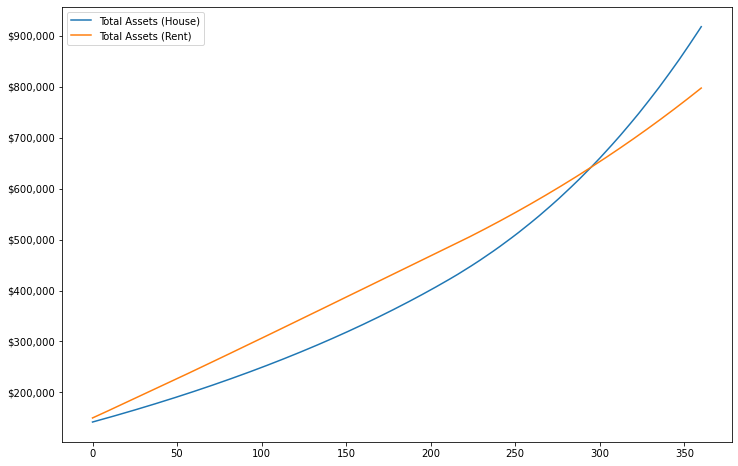

In [144]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(house_sim['period'], house_sim['HOUSE_Total_Capital+Equity'], label="Total Assets (House)")
ax.plot(house_sim['period'], house_sim['APT_Total_Assets'], label="Total Assets (Rent)")
ax.legend()
ax.yaxis.set_major_formatter( '${x:,.0f}')
plt.show()

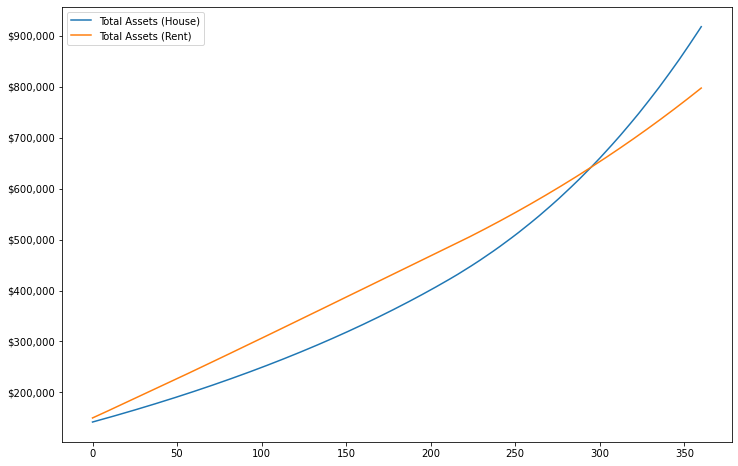

In [133]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(house_sim['period'], house_sim['HOUSE_Total_Capital+Equity'], label="Total Assets (House)")
ax.plot(house_sim['period'], house_sim['APT_Total_Assets'], label="Total Assets (Rent)")
ax.legend()
ax.yaxis.set_major_formatter( '${x:,.0f}')
plt.show()

In [160]:
tuning_dp = pd.DataFrame(columns=['period'])
for dp in range(10000, 200000, 25000):
    house_sim = sim_table(mortgage_rate = .08, n_years = 30, realestate_cost = 385000,
            down_payment = dp, available_capital = 150000, investment_return = .04, rent = 2100,
          realtor_fees = 0, moving_cost = 3000, borrowing_cost = 5000, property_tax = .01,
            hoa = 500, rent_increase_percent = .025, house_growth = .015)
    house_sim = house_sim[['period', 'HOUSE_Total_Capital+Equity']].rename(columns={'HOUSE_Total_Capital+Equity': '${:,.0f} DP'.format(dp)})
    tuning_dp = pd.merge(tuning_dp, house_sim, how='outer', on='period')
tuning_dp = tuning_dp.set_index('period')

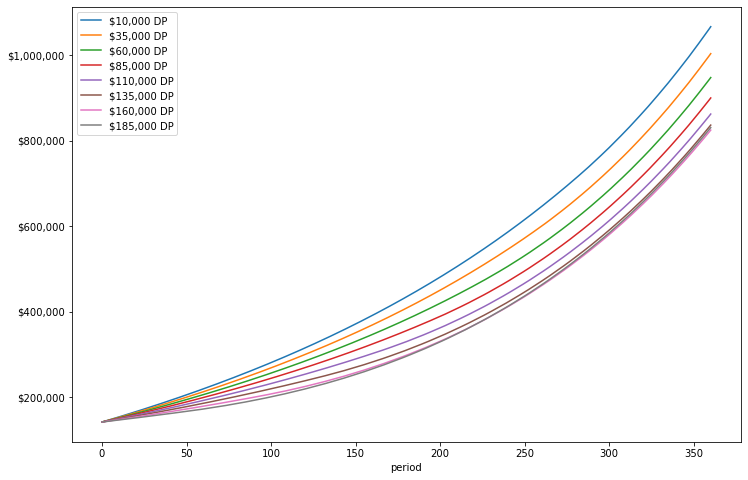

In [161]:
fig, ax = plt.subplots(figsize=(12,8))
tuning_dp.plot(ax=ax)
ax.legend()
ax.yaxis.set_major_formatter( '${x:,.0f}')
plt.show()

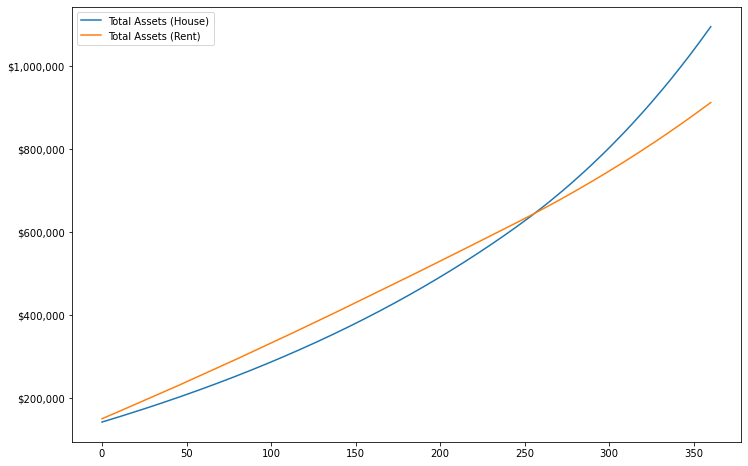

In [165]:
house_sim = sim_table(mortgage_rate = .07, n_years = 30, realestate_cost = 385000,
            down_payment = 10000, available_capital = 150000, investment_return = .04, rent = 2100,
          realtor_fees = 0, moving_cost = 3000, borrowing_cost = 5000, property_tax = .01,
            hoa = 500, rent_increase_percent = .025, house_growth = .015)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(house_sim['period'], house_sim['HOUSE_Total_Capital+Equity'], label="Total Assets (House)")
ax.plot(house_sim['period'], house_sim['APT_Total_Assets'], label="Total Assets (Rent)")
ax.legend()
ax.yaxis.set_major_formatter( '${x:,.0f}')
plt.show()